In [1]:
import glob
import os

import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')

import pandas as pd
import numpy as np

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from torch.utils.data.dataloader import DataLoader

from neuroformer.model_neuroformer import load_model_and_tokenizer
from neuroformer.utils import get_attr
from neuroformer.utils import (set_seed, running_jupyter, 
                                 all_device, recursive_print,
                                 create_modalities_dict)
from neuroformer.datasets import load_visnav, load_V1AL

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

from neuroformer.default_args import DefaultArgs, parse_args

if running_jupyter(): # or __name__ == "__main__":
    print("Running in Jupyter")
    args = DefaultArgs()
    # args.dataset = "medial"
    # args.ckpt_path = "./models/NF.15/Visnav_VR_Expt/medial/Neuroformer/predict_all_behavior/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25"
    
    args.dataset = "lateral"
    args.ckpt_path = "./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/predict_all/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25"
    args.predict_modes = ['speed']
else:
    print("Running in terminal")
    args = parse_args()


# SET SEED - VERY IMPORTANT
set_seed(args.seed)

print(f"CONTRASTIUVEEEEEEE {args.contrastive}")
print(f"VISUAL: {args.visual}")
print(f"PAST_STATE: {args.past_state}")


config, tokenizer, model = load_model_and_tokenizer(args.ckpt_path)

/local/home/antonis/.conda/envs/neuroformer_clean/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running in Jupyter
CONTRASTIUVEEEEEEE False
VISUAL: True
PAST_STATE: True
256 9


11/22/2023 15:02:22 - INFO - neuroformer.model_neuroformer -   number of parameters: 2.820302e+07


 ///// <=----- Loading model from ./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/predict_all/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25 -----=> \\\


In [2]:
""" 

-- DATA --
neuroformer/data/OneCombo3_V1AL/
df = response
video_stack = stimulus
DOWNLOAD DATA URL = https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=sharing


"""
print(f"DATASET: {args.dataset}")
if args.dataset in ["lateral", "medial"]:
    data, intervals, train_intervals, \
    test_intervals, finetune_intervals, \
    callback = load_visnav(args.dataset, config, 
                           selection=config.selection if hasattr(config, "selection") else None)
elif args.dataset == "V1AL":
    data, intervals, train_intervals, \
    test_intervals, finetune_intervals, \
    callback = load_V1AL(config)

spikes = data['spikes']
stimulus = data['stimulus']

DATASET: lateral


In [3]:
window = config.window.curr
window_prev = config.window.prev
dt = config.resolution.dt


# -------- #

spikes_dict = {
    "ID": data['spikes'],
    "Frames": data['stimulus'],
    "Interval": intervals,
    "dt": config.resolution.dt,
    "id_block_size": config.block_size.id,
    "prev_id_block_size": config.block_size.prev_id,
    "frame_block_size": config.block_size.frame,
    "window": config.window.curr,
    "window_prev": config.window.prev,
    "frame_window": config.window.frame,
}

""" structure:
{
    type_of_modality:
        {name of modality: {'data':data, 'dt': dt, 'predict': True/False},
        ...
        }
    ...
}
"""



" structure:\n{\n    type_of_modality:\n        {name of modality: {'data':data, 'dt': dt, 'predict': True/False},\n        ...\n        }\n    ...\n}\n"

In [4]:
config.window.frame

0.15

In [5]:
from neuroformer.data_utils import NFDataloader

n_test_iters = 2000
n_test_idx = np.random.choice(len(test_intervals), n_test_iters, replace=False)
test_intervals = test_intervals[n_test_idx]

modalities = create_modalities_dict(data, config.modalities)
frames = {'feats': stimulus, 'callback': callback, 'window': config.window.frame, 'dt': config.resolution.dt}

train_dataset = NFDataloader(spikes_dict, tokenizer, config, dataset=args.dataset, 
                             frames=frames, intervals=train_intervals, modalities=modalities)
test_dataset = NFDataloader(spikes_dict, tokenizer, config, dataset=args.dataset, 
                            frames=frames, intervals=test_intervals, modalities=modalities)
finetune_dataset = NFDataloader(spikes_dict, tokenizer, config, dataset=args.dataset, 
                                frames=frames, intervals=finetune_intervals, modalities=modalities)

    
# print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')
iterable = iter(train_dataset)
x, y = next(iterable)
recursive_print(x)

# Update the config
config.id_vocab_size = tokenizer.ID_vocab_size

# Create a DataLoader
loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)
iterable = iter(loader)
x, y = next(iterable)
recursive_print(y)
preds, features, loss = model(x, y)

# Set training parameters
MAX_EPOCHS = 300
BATCH_SIZE = 32 * 5
SHUFFLE = True

if config.gru_only:
    model_name = "GRU"
elif config.mlp_only:
    model_name = "MLP"
elif config.gru2_only:
    model_name = "GRU_2.0"
else:
    model_name = "Neuroformer"

CKPT_PATH = args.ckpt_path

# Define the parameters
sample = True
top_p = 0.95
top_p_t = 0.95
temp = 1.
temp_t = 1.
frame_end = 0
true_past = args.true_past
get_dt = True
gpu = True
pred_dt = True

# # Run the prediction function
# results_trial = generate_spikes(model, test_dataset, window, 
#                                 window_prev, tokenizer, 
#                                 sample=sample, top_p=top_p, top_p_t=top_p_t, 
#                                 temp=temp, temp_t=temp_t, frame_end=frame_end, 
#                                 true_past=true_past,
#                                 get_dt=get_dt, gpu=gpu, pred_dt=pred_dt,
#                                 plot_probs=False)

# # Create a filename string with the parameters
# filename = f"results_trial_sample-{sample}_top_p-{top_p}_top_p_t-{top_p_t}_temp-{temp}_temp_t-{temp_t}_frame_end-{frame_end}_true_past-{true_past}_get_dt-{get_dt}_gpu-{gpu}_pred_dt-{pred_dt}.pkl"

# # Save the results in a pickle file
# save_inference_path = os.path.join(CKPT_PATH, "inference")
# if not os.path.exists(save_inference_path):
#     os.makedirs(save_inference_path)

# print(f"Saving inference results in {os.path.join(save_inference_path, filename)}")

# with open(os.path.join(save_inference_path, filename), "wb") as f:
#     pickle.dump(results_trial, f)


Min Interval: 0.1
Intervals:  24092
Window:  0.05
Window Prev:  0.05
Population Size:  2026
ID Population Size:  2026
DT Population Size:  9
Using explicitly passed intervals
Min Interval: 0.1
Intervals:  2000
Window:  0.05
Window Prev:  0.05
Population Size:  2026
ID Population Size:  2026
DT Population Size:  9
Using explicitly passed intervals
Min Interval: 0.1
Intervals:  240
Window:  0.05
Window Prev:  0.05
Population Size:  2026
ID Population Size:  2026
DT Population Size:  9
Using explicitly passed intervals
id_prev torch.Size([700]) torch.int64
dt_prev torch.Size([700]) torch.float32
pad_prev torch.Size([]) torch.int64
id torch.Size([100]) torch.int64
dt torch.Size([100]) torch.float32
pad torch.Size([]) torch.int64
interval torch.Size([]) torch.float32
trial torch.Size([]) torch.int64
frames torch.Size([1, 3, 30, 100]) torch.float32
cid torch.Size([2]) torch.float32
pid torch.Size([2]) torch.float32
id torch.Size([2, 100]) torch.int64
dt torch.Size([2, 100]) torch.int64
modal

In [6]:
preds, features, loss = model(x, y)

In [7]:
loss.keys()

dict_keys(['phi', 'speed', 'th', 'id', 'time'])

In [8]:
features.keys()
preds.keys()

dict_keys(['phi', 'speed', 'th', 'probs_id', 'precision', 'recall', 'F1', 'id', 'dt'])

In [9]:
# predict other modality
from neuroformer.simulation import decode_modality
# model.load_state_dict(torch.load(os.path.join(CKPT_PATH, f"_epoch_speed.pt"), map_location=torch.device('cpu')))
model.load_state_dict(torch.load(os.path.join(CKPT_PATH, f"model.pt"), map_location=torch.device('cpu')))
args.predict_modes = ['speed', 'phi', 'th']
behavior_preds = {}
if args.predict_modes is not None:
    block_type = 'behavior'
    block_config = get_attr(config.modalities, block_type).variables
    for mode in args.predict_modes:
        mode_config = get_attr(block_config, mode)
        mode_path = os.path.join(CKPT_PATH, f"_epoch_{mode}.pt")
        if os.path.exists(mode_path):
            print(f"Loading model {mode_path}")
            model.load_state_dict(torch.load(mode_path, map_location=torch.device('cpu')))
        behavior_preds[mode] = decode_modality(model, test_dataset, modality=mode, 
                                          block_type=block_type, objective=get_attr(mode_config, 'objective'))
        filename = f"behavior_preds_{mode}.csv"
        save_inference_path = os.path.join(CKPT_PATH, "inference")
        if not os.path.exists(save_inference_path):
            os.makedirs(save_inference_path)
        print(f"Saving inference results in {os.path.join(save_inference_path, filename)}")
        behavior_preds[mode].to_csv(os.path.join(save_inference_path, filename))

Loading model ./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/predict_all/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25/_epoch_speed.pt


100%|██████████| 40/40 [00:47<00:00,  1.19s/it]


Saving inference results in ./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/predict_all/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25/inference/behavior_preds_speed.csv
Loading model ./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/predict_all/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25/_epoch_phi.pt


100%|██████████| 40/40 [00:46<00:00,  1.17s/it]


Saving inference results in ./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/predict_all/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25/inference/behavior_preds_phi.csv


100%|██████████| 40/40 [00:47<00:00,  1.18s/it]

Saving inference results in ./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/predict_all/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25/inference/behavior_preds_th.csv


/share/edc/home/antonis/neuroformer_clean/Neuroformer/neuroformer/visualize.py:1063: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(combined_limits, combined_limits, 'k--', color='black')
/share/edc/home/antonis/neuroformer_clean/Neuroformer/neuroformer/visualize.py:1063: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(combined_limits, combined_limits, 'k--', color='black')
/share/edc/home/antonis/neuroformer_clean/Neuroformer/neuroformer/visualize.py:1063: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(combined_limits, combined_limits, 'k--', color='black')


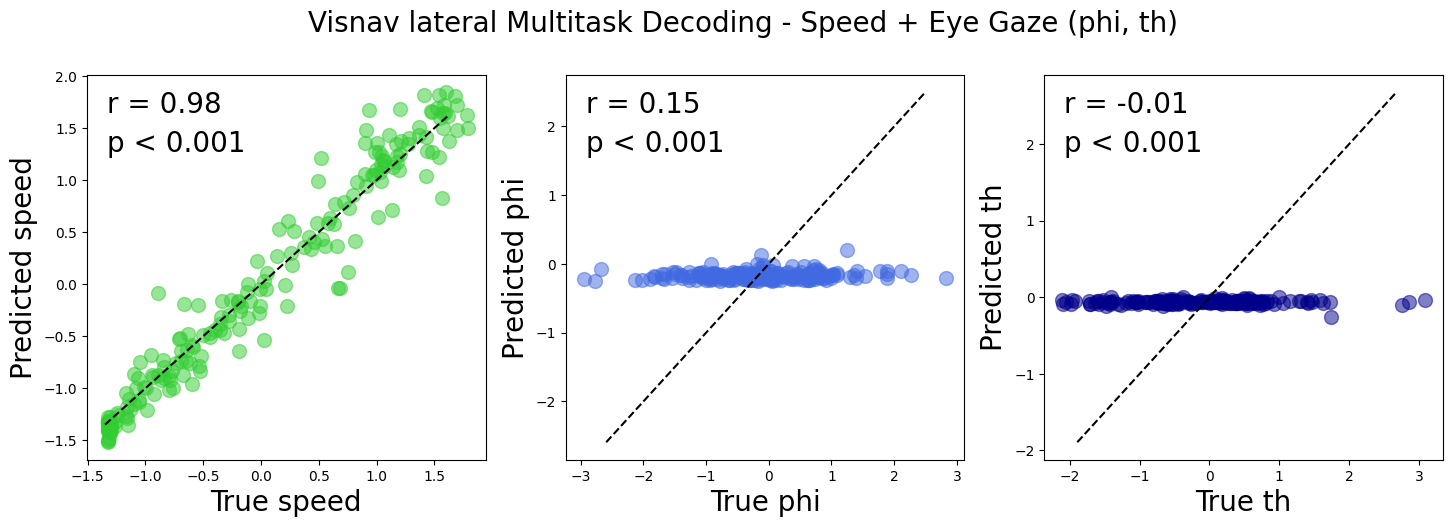

In [10]:
from neuroformer.visualize import plot_regression

fig, ax = plt.subplots(figsize=(17.5, 5), nrows=1, ncols=len(args.predict_modes))
plt.suptitle(f'Visnav {args.dataset} Multitask Decoding - Speed + Eye Gaze (phi, th)', fontsize=20, y=1.01)
colors = ['limegreen', 'royalblue', 'darkblue']  # Define your colors here

for n, mode in enumerate(args.predict_modes):
    behavior_preds_mode = behavior_preds[mode]
    x_true, y_true = behavior_preds_mode['cum_interval'][:200], behavior_preds_mode['true'][:200]  # Limit to 200 examples
    x_pred, y_pred = behavior_preds_mode['cum_interval'][:200], behavior_preds_mode[f'behavior_{mode}_value'][:200]  # Limit to 200 examples
    r, p = pearsonr([float(y) for y in y_pred], [float(y) for y in y_true])
    axis = ax[n]
    plot_regression(y_true, y_pred, mode, model_name, r, p, ax=axis, color=colors[n], save_path=args.ckpt_path)  # Use color